## Digit recognition: Logistic Regression

**Strategy:** First classify digits individually. Then classify data into 10 classes (multivariate). <br/>
**Cost function:** Log loss
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import show
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss, roc_curve
import statsmodels.api as sm
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV

**Get the data**

In [2]:
raw_training_data = pd.read_csv("data/zip.train", header=None , sep=" ")
test_data = pd.read_csv("data/zip.test", header=None , sep=" ")

**Functions for removing NaN and rename target column**

In [3]:
def remove_nan (df):
    return df.dropna(axis=1, how='any',thresh=None)

def rename_labels (df):
    return df.rename(columns={0:'Labels'}, inplace=True)

**Clean data with the help of above functions**

In [4]:
rename_labels(raw_training_data)
training_data = remove_nan(raw_training_data) # Give the training data a new, better name

rename_labels(test_data) # There are no NaN values in the test set

**Reserve some training data for validating**

In [5]:
training_data, extra_training_data = train_test_split(training_data, test_size=0.05, random_state=11)


**Check out the digit distribution among data sets**

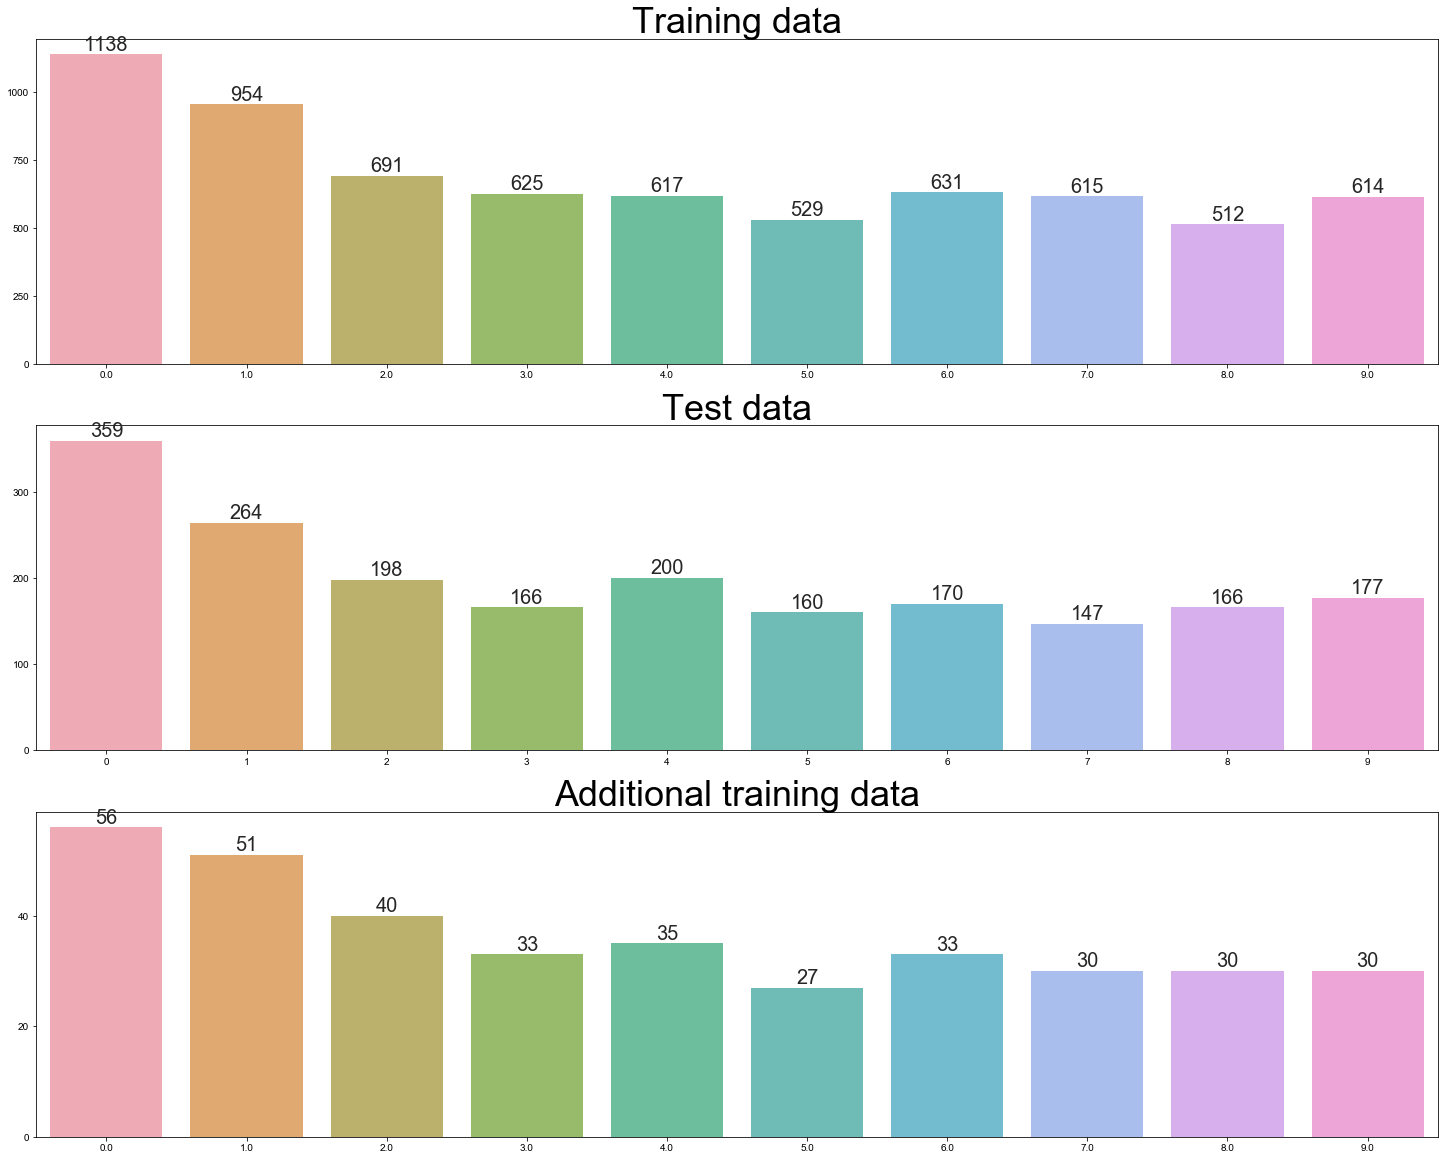

In [6]:
traincount = pd.value_counts(training_data['Labels'].values, sort=True)
extracount = pd.value_counts(extra_training_data['Labels'].values,sort=True)
testcount = pd.value_counts(test_data['Labels'].values, sort=True)

f,(ax1,ax2,ax3) = plt.subplots(3,constrained_layout=True,figsize=(20,16))
sns.set(font_scale=3)
sns.barplot(traincount.index, traincount.values, alpha=0.8,ax=ax1)
sns.barplot(testcount.index, testcount.values, alpha=0.8,ax=ax2)
sns.barplot(extracount.index, extracount.values, alpha=0.8,ax=ax3)

ax1.set_title('Training data',)
ax2.set_title('Test data')
ax3.set_title('Additional training data')


for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=20, ha='center', va='bottom')

    
for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=20, ha='center', va='bottom')

for p in ax3.patches:
    ax3.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=20, ha='center', va='bottom')


plt.show()



The digits appear to be similarly distributed among train, extra, and test sets. <br/> However the digits are not even close to being evenly distributed. <br/> What implications might this have on the strength of the model?

## Class DigitFrame
- Make dataframes easier to use
- Fit to a logistic regression classifier
- Given a test set, returns predictions and predicted probabilities
- Organizes the results of logistic regression in a DataFrame
- Object instances are data sets (train, validate, test)

In [128]:
class DigitFrame :
    
    def __init__ (self,df):
        self.df = df

    def remove_labels(self):
        return self.df.drop('Labels',axis=1)
    
    def get_labels(self):
        return self.df['Labels']    

    def get_classified (self,digit):
        return (self.df['Labels'] == digit).astype(np.int)
        # returns labels as class (0 or 1). When label == digit, class 1, else 0.
    
    def logreg_fit(self,digit):
        X = self.remove_labels()
        y = self.get_classified(digit)
        logreg = LogisticRegression()
        logreg.fit(X,y)
        return logreg
        # returns an instance of logreg classifier for given digit
    
    def predict_it (self,digit,testdf):
        return pd.DataFrame((self.logreg_fit(digit)).predict(testdf))
        # returns model predictions (0 or 1) of given y_test and digit
    
    def get_prob (self,digit,testdf):
        return pd.DataFrame((self.logreg_fit(digit)).predict_proba(testdf))
        # returns predicted probabilities for each class (0 or 1), at each instance,
        # organized in a dataframe

    def get_log_loss (self,digit,testdf_wlbl):
        y_predict = self.predict_it(digit,(testdf_wlbl.drop('Labels',axis=1)))
        y_true = (testdf_wlbl['Labels'] == digit).astype(np.int)
        return log_loss (y_predict,y_true)
        # The input test dataframe MUST come with a label
     

    def get_results (self,test_obj):
        predict_list = []
        true_list = []
        logloss_list = []
        for i in range (0,10) :
            predict = (self.predict_it(i,test_obj.remove_labels())).sum()
            predict_list.append(predict[0])
            true_list.append(test_obj.get_classified(i).sum())
            logloss_list.append(self.get_log_loss(i,test_obj.df))
        results = pd.DataFrame()
        results['Predict'] = predict_list
        results['True'] = true_list
        results['Log loss'] = logloss_list
        return results
        # Takes test set as object, returns results from running model fitted by self


## Initialize DigitFrames

In [228]:
train = DigitFrame(training_data)
y_train = train.remove_labels()

validate = DigitFrame(extra_training_data)
y_validate = validate.remove_labels()

test = DigitFrame(test_data)
y_test = test.remove_labels()

## Logistic Regression for each digit

- Initialize a classifier instance
- Fit 
- Predict
- Measure

** With the training data**

In [229]:
train_results = train.get_results(train)
train_results

,Predict,True,Log loss
0,1134,1138,0.069817
1,955,954,0.014961
2,660,691,0.244359
3,604,625,0.274280
4,602,617,0.294227
5,506,529,0.224411
6,626,631,0.114699
7,607,615,0.099738
8,461,512,0.483731
9,602,614,0.379004


**With the extra training data**

In [230]:
validate_results = train.get_results(validate)
validate_results

,Predict,True,Log loss
0,58,56,0.567765
1,49,51,0.378514
2,40,40,0.567767
3,34,33,0.662394
4,36,35,1.040906
5,27,27,1.135535
6,30,33,0.283887
7,32,30,0.378509
8,34,30,0.567763
9,28,30,0.378514


**With the test data**

In [231]:
test_results = train.get_results(test)
test_results

,Predict,True,Log loss
0,365,359,0.619536
1,254,264,0.275352
2,180,198,0.998146
3,165,166,1.118608
4,195,200,1.049772
5,149,160,0.808842
6,168,170,0.481862
7,144,147,0.395816
8,151,166,1.221867
9,199,177,0.894882


** Why is the log loss so different for different digits?**
<br/>Where is the model lacking flexibility/sensitivity ?

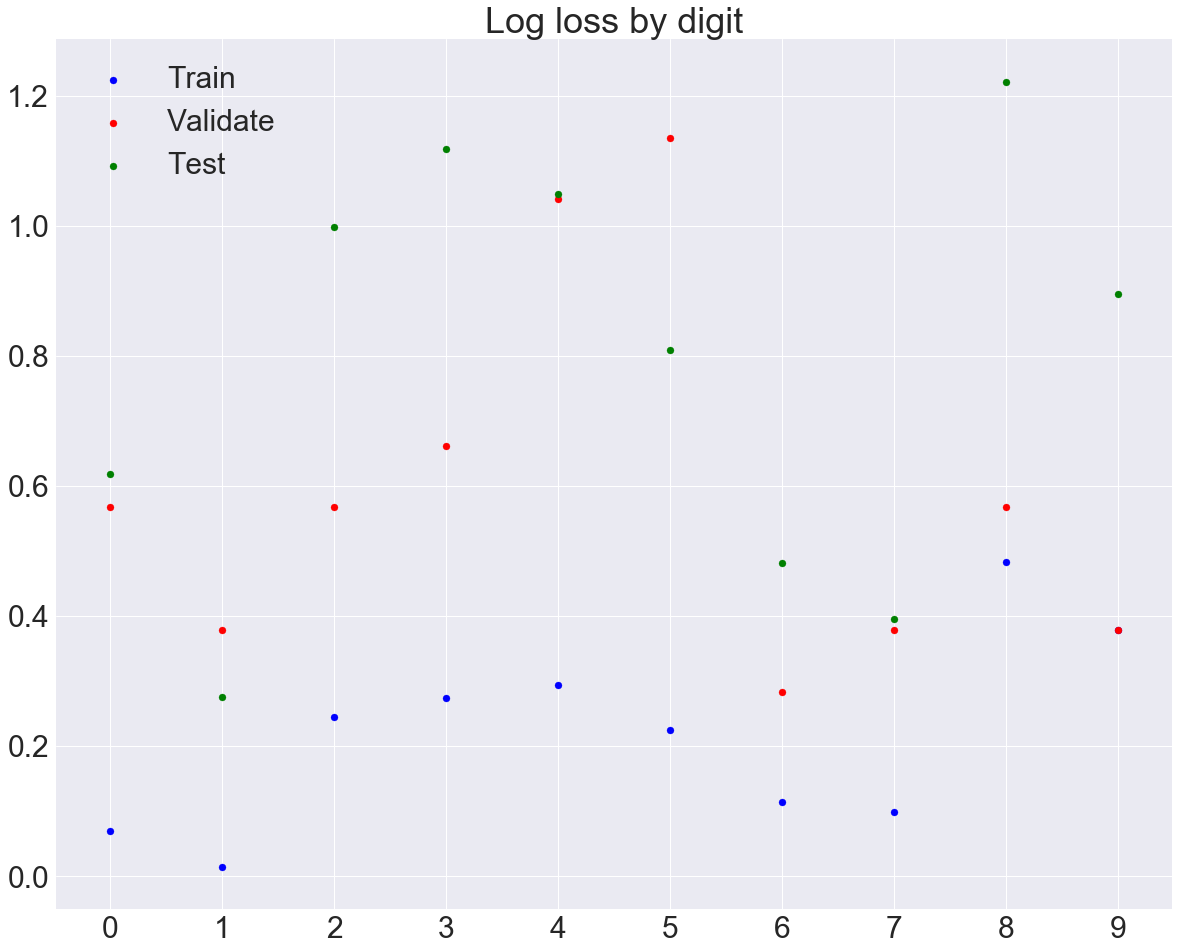

In [232]:
x = train_results['Log loss'].index.values
y1 = train_results['Log loss'].values
y2 = validate_results['Log loss'].values
y3 = test_results['Log loss'].values

plt.figure(figsize=(20,16))
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

plt.scatter(x,y1,c='b')
plt.scatter(x,y2,c='r')
plt.scatter(x,y3,c='g')

plt.legend(['Train','Validate','Test'], loc='best')

plt.title('Log loss by digit')



plt.show()

What's going on with this difference between validation and test sets?


## Tricky Digits
A handful of digits that are not so easily classified by the model.

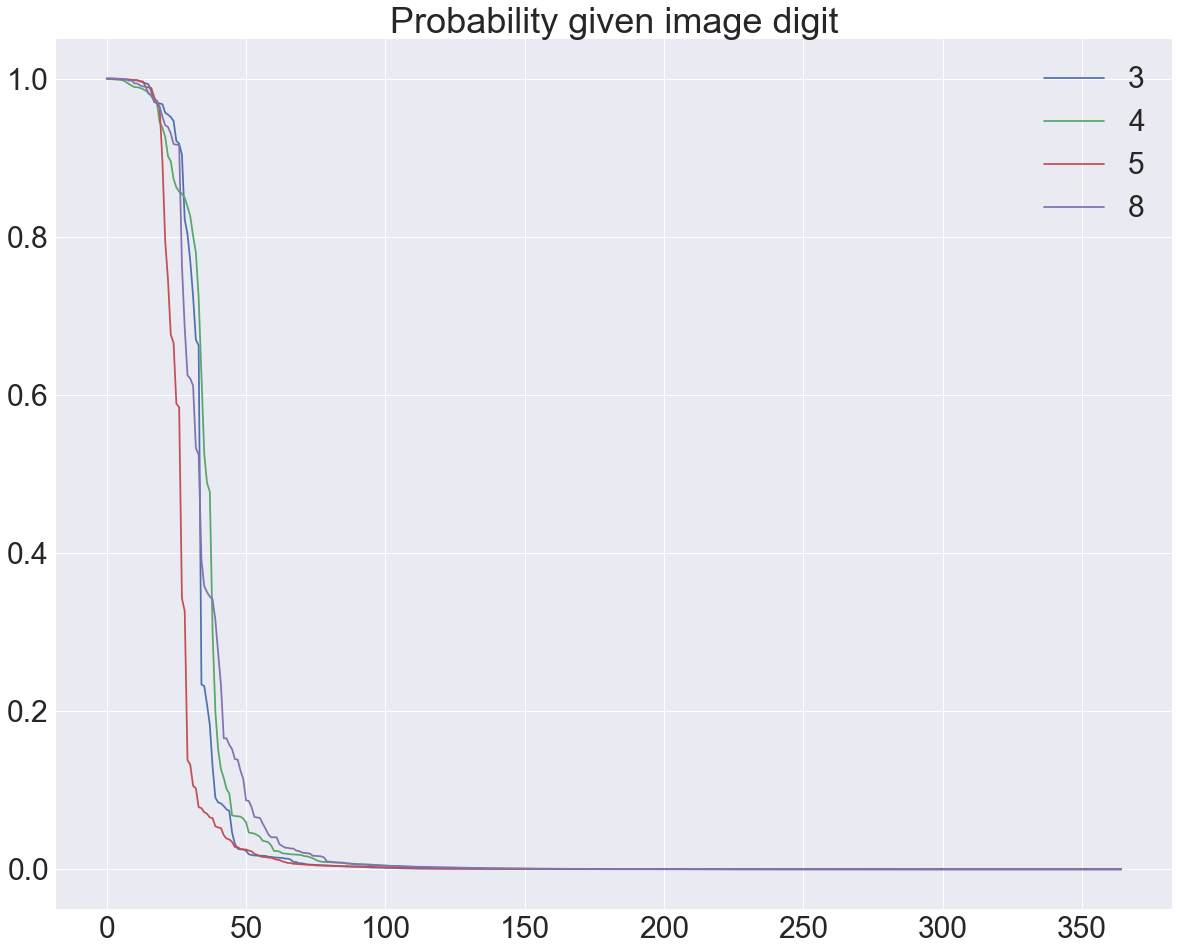

In [256]:

plt.figure(figsize=(20,16))
x = list(range(0,365))
y1 = (train.get_prob(digit=3,testdf=y_validate)[1]).sort_values(ascending=False)
y2 = (train.get_prob(digit=4,testdf=y_validate)[1]).sort_values(ascending=False)
y3 = (train.get_prob(digit=5,testdf=y_validate)[1]).sort_values(ascending=False)
y4 = (train.get_prob(digit=8,testdf=y_validate)[1]).sort_values(ascending=False)

plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.title('Probability given image digit')

plt.legend(['3','4','5','8'], loc='best')
plt.show();



Hmm... probability as area under the curve... this seems like a job for Calculus! :) <br/> This is something to come back to.

**Trying to plot the log_loss and probabilities**
<br/> (It didn't really work out)

## Multinomial Logistic Regression##
Ten digits: Ten classes/categories

**Organize training data into digit and not-digit (input and targets)**

In [269]:
X_train = training_data.drop('Labels',axis=1)
X_extra = (extra_training_data).drop('Labels',axis=1)
X_test = (test_data).drop('Labels',axis=1)

y_train = (training_data)['Labels']
y_extra = (extra_training_data)['Labels']
y_test =  (test_data)['Labels']


**Initialize a classifer instance**

In [270]:
logisticRegr = LogisticRegression(solver = 'lbfgs',C=0.5,multi_class='multinomial')

**Fit the model**

In [271]:
logisticRegr.fit(X=X_train,y=y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**Evaluate the model**

Training set

In [272]:
train_prediction = logisticRegr.predict(X=X_train)
train_score = logisticRegr.score(X_train, y_train)
train_score

0.9907594571181056

Extra training data

In [273]:
extra_prediction = logisticRegr.predict(X=X_extra)
extra_score = logisticRegr.score(X_extra, y_extra)
extra_score

0.9342465753424658

Test data

In [274]:
test_prediction = logisticRegr.predict(X=X_test)
test_score = logisticRegr.score(X_test,y_test)
test_score

0.911310413552566

Log loss: Is this possible with multivariate logistic regression? I have only errors.

In [275]:
#log_loss(y_pred=test_prediction,y_true=y_test)

Further analysis of test results

In [276]:
print(classification_report(y_test, test_prediction))

             precision    recall  f1-score   support

          0       0.95      0.97      0.96       359
          1       0.99      0.95      0.97       264
          2       0.90      0.85      0.88       198
          3       0.84      0.90      0.87       166
          4       0.86      0.88      0.87       200
          5       0.87      0.86      0.86       160
          6       0.94      0.93      0.93       170
          7       0.91      0.91      0.91       147
          8       0.88      0.84      0.86       166
          9       0.89      0.94      0.91       177

avg / total       0.91      0.91      0.91      2007



**Observations:** Looking at the model as a whole, it correctly classifies images 91% of the time. Looking at the digit three specifically, when our model claims an image represents the number three, it is correct 84% of the time. Additionally, it detects 90% of the threes. Having a look at the f1 scores, our model isn't too bad.

**Confusion matrix**

In [279]:
matrix = confusion_matrix(y_test,test_prediction)
print (matrix)

[[348   0   1   3   3   1   1   0   1   1]
 [  0 252   0   3   3   0   3   1   1   1]
 [  2   0 169   5   8   2   2   2   7   1]
 [  1   0   3 150   1   6   0   2   2   1]
 [  2   2   7   1 176   1   1   2   2   6]
 [  4   0   0   9   1 137   3   1   2   3]
 [  2   0   2   0   4   3 158   0   1   0]
 [  0   0   1   3   4   0   0 134   0   5]
 [  6   0   5   4   2   6   0   1 139   3]
 [  0   1   0   0   2   1   0   4   3 166]]


Numbers are beautiful, but for those who like less numeric visualizations: <br/> Confusion matrix with grayscale

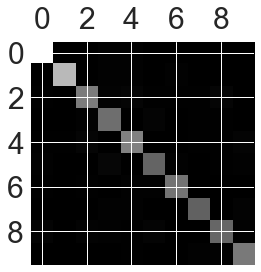

In [280]:
plt.matshow(cm,cmap=plt.cm.gray)
plt.show()

When looking at what the model does well, everything seems peachy.  But I'm interested in where the model has problems and makes mistakes. I am still figuring out this code (thanks, textbook!)

In [282]:
row_sums = (matrix.sum(axis=1,keepdims=True))
norm_conf_mx = matrix / (row_sums)

*(Here is another example of Python 2 and Python 3 differences with float division)*

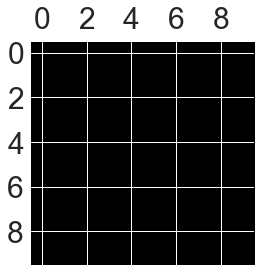

In [283]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

The rows are the actual categories, and the columns are the predicted categories. The bright spots let us know where the model has misclassified results. Five appears to be a tricky digit. And it's often misclassified as three. I wonder why? Do we have any mistakes in our training data? Have we forgotten to remove any labels? Or is this error really a product of the model?

##  Everybody (or model) makes mistakes##


In [358]:

true = pd.DataFrame(validate.get_classified(digit=3))
pred = train.predict_it(digit=3,testdf=validate.remove_labels())
true.index = pred.index
three_df = pd.concat([true, pred], axis= 1)
labels = validate.get_labels()
three_df.index=labels.index
three_df = pd.concat([three_df, labels], axis= 1)
three_df.columns=('True','Predict','Labels')


mistake_df = three_df.drop(three_df[(three_df['Predict'] == 1) & (three_df['True'] == 1)].index)
mistake_df = mistake_df.drop(mistake_df[(mistake_df['Predict'] == 0) & (mistake_df['True'] == 0)].index)


In [359]:
mistake_df

,True,Predict,Labels
5804,1,0,3.0
3128,0,1,7.0
3366,0,1,5.0
1437,0,1,2.0
4124,1,0,3.0
3926,1,0,3.0
4816,0,1,7.0


**Which images confused our model?**

In [405]:
mistake_df

,level_0,index,True,Predict,Labels
0,0,5804,1,0,3.0
1,1,3128,0,1,7.0
2,2,3366,0,1,5.0
3,3,1437,0,1,2.0
4,4,4124,1,0,3.0
5,5,3926,1,0,3.0
6,6,4816,0,1,7.0


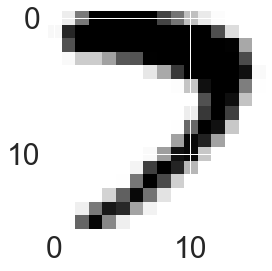

In [420]:

def getNumberImage(data):
    return data.values.reshape(16,16)

#mistake_df.reset_index()
for i in range (0,len(mistake_df)) :
    j = mistake_df['index'][i]
    data= validate.remove_labels().loc[j,:]
    getNumberImage(data)
    plt.imshow(getNumberImage(data), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show();
    i += 1
   


## Next steps:##
Finding similarities in mistakes, isolating them, improving model

** Continuing to analyze the results**

In [ ]:
some_digit = remove_labels(test_data).iloc[0,:]
some_scores = logisticRegr.decision_function([some_digit])
some_scores

Is this a nine? That has the highest score.

In [267]:
data = (test_data).iloc[0,1:]

plt.imshow(getNumberImage(data), cmap=plt.cm.gray_r, interpolation='nearest')

NameError: name 'getNumberImage' is not defined

## TBD

In [ ]:


def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -math.log(p)
    else:
        return -math.log(1 - p)


def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -math.log(p)
    else:
        return -math.log(1 - p)

logloss_list = []

for i in (three_df.index):
    logloss_list.append(logloss(three_df['True'][i],three_df['Predict'][i]))
    
three_df.reset_index()
three_df['LogLoss'] = logloss_list

three_df.head()







def prob_df (train_obj,test_obj,digit):
    #prob_dig = train_obj.get_prob(digit=i,testdf)[1]
    dig_df = test_obj.df.copy()
    
    dig_df['P of ' + str(digit)] = (train_obj.get_prob(digit,test_obj.remove_labels())[1])
    dig_df['Predict'] = train_obj.predict_it(digit,test_obj.remove_labels())
    dig_df['True'] = test_obj.get_classified(digit)
    
    logloss_list = []
    #dig_df.reset_index()
    #or i in (dig_df.index):
    #   logloss_list.append(logloss(dig_df['True'][i],dig_df['Predict'][i]))
    
   
    dig_df['LogLoss'] = logloss_list
    return dig_df





#def remove_labels(df):
#    return df.drop('Labels',axis=1)
#   
#def get_labels(df):
#    return (df['Labels'])
#
#


#'{0:.2f}'.format(traincount[0]/float(traincount.sum())*100)



#print (logreg_8.predict_proba(df)) # Pretty confident it's an 8
#print (logreg_0.predict_proba(df)) # Pretty condifent it's not a 0

#kt =((logreg_8.predict_proba(df))[0][1]) # Probability it's true
#
#
#print ("%.2f%%" % (kt*100))

#
#x = three_df['P(=3)']
#y = three_df['LogLoss']
#
#plt.scatter(x,y)
#plt.show()
#
three_df_2 = three_df.copy()
three_df_2 = three_df_2.drop(three_df_2[(three_df_2['LogLoss']>1)==True].index)
three_df = three_df.sort_values('P(=3)')

x = three_df['P(=3)']
y = three_df['LogLoss']

#plt.ylim(ymax=0.005)  # adjust the max leaving min unchanged
#plt.ylim(ymin=0)  # adjust the min leaving max unchanged

plt.scatter(x,y)
plt.show()


#three_df_2